In [1]:
%matplotlib inline
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from proteus.visu import matrix as visu
from proteus.matrix import tseries as ts
import nibabel as nib
from nibabel.affines import apply_affine
import pandas as pd
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression
from nilearn.masking import compute_epi_mask

# Load data low motion
we load the data depending on the source HC0040123, SZ0040142 and SZ0040084

In [2]:
subj_id='HC0040123'

In [3]:
# original subject from pierre exp
covar = pd.read_csv('/home/cdansereau/data/deepmotion/cobre/xp_2016_07_27_final/fmri_'+subj_id+'_session1_run1_n_confounds.tsv.gz',sep='\t')
covar.columns
vol_nii = nib.load('/home/cdansereau/data/deepmotion/cobre/xp_2016_07_27_final/rest_'+subj_id+'.nii.gz')


We extract the functional volume and relevant covariates (slow time drift and motion params)

In [4]:
vol = vol_nii.get_data()
Xmotion = covar.iloc[:,0:6].values
Xdrift  = covar.iloc[:,8:14].values
fd = covar['FD'].values

# Extract mask

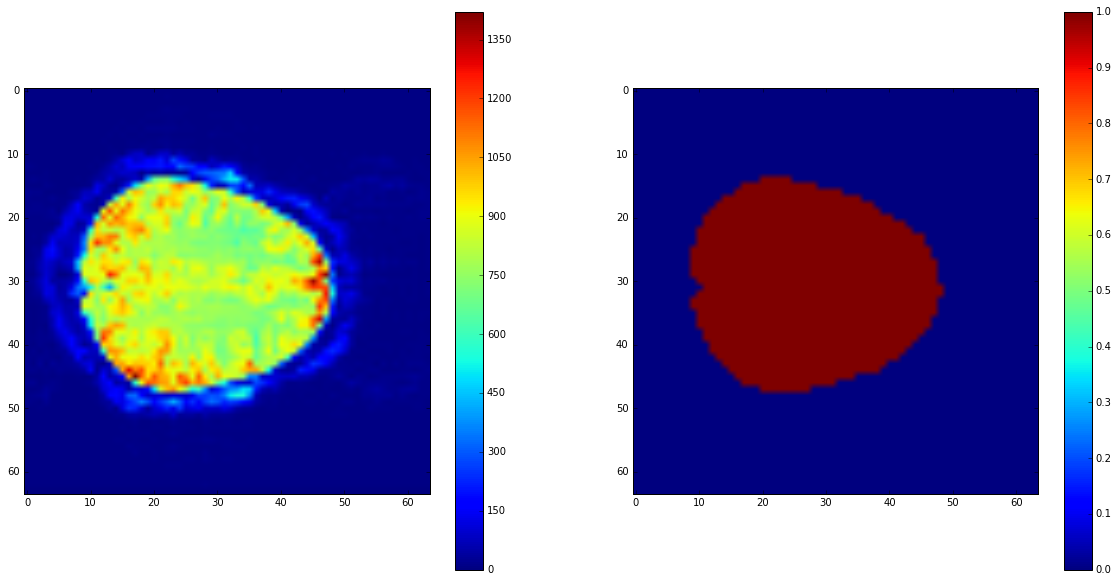

In [5]:
# compute the functional mask for the subject
mask_b = compute_epi_mask(vol_nii).get_data().astype(bool)

# show functional 
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(vol.mean(3)[:,:,20])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(mask_b[:,:,20],clim=(0.0, 1.))
plt.colorbar()

Create some functional to help with the visualization

In [6]:
# R2 score
def getR2(y,ypred):
    R2 = 1. - np.sum((y-ypred)**2,0)/np.sum(y**2,0)
    return R2 

def getMap(val,mask):
    if len(val.shape)==2:
        new_map = np.zeros((mask.shape[0],mask.shape[1],mask.shape[2],val.shape[1])).astype(float)
    else:
        new_map = np.zeros_like(mask).astype(float)
    new_map[mask] = val
    return new_map

def getspec(vol):
    nx,ny,nz = vol.shape
    nrows = int(np.ceil(np.sqrt(nz)))
    ncolumns = int(np.ceil(nz/(1.*nrows)))
    return nrows,ncolumns,nx,ny,nz

def montage(vol1):

    vol = np.swapaxes(vol1,0,1)
    nrows,ncolumns,nx,ny,nz = getspec(vol)

    mozaic = np.zeros((nrows*nx,ncolumns*ny))
    indx,indy = np.where(np.ones((nrows,ncolumns)))

    for ii in np.arange(vol.shape[2]):
        # we need to flip the image in the x axis
        mozaic[(indx[ii]*nx):((indx[ii]+1)*nx),(indy[ii]*ny):((indy[ii]+1)*ny)] = vol[::-1,:,ii]

    return mozaic

# Linear regression

simple linear regression from all the sample

In [7]:
X = Xmotion
y = vol[mask_b].T

lreg_drift = LinearRegression(fit_intercept=True)
lreg_drift.fit(Xdrift,y)
new_y = y-lreg_drift.predict(Xdrift)

lreg_motion = LinearRegression(fit_intercept=True)
lreg_motion.fit(Xdrift,Xmotion)
new_Xmotion = Xmotion - lreg_motion.predict(Xdrift)

lreg = LinearRegression(fit_intercept=False)
lreg.fit(new_Xmotion,new_y)

ypred = lreg.predict(new_Xmotion)
R2 = getR2(new_y,ypred)

print 'Average R2: ',R2.mean()

Average R2:  0.260504520922


We can now look at the beta values from the trainned model to see the corresponding map for each input parameter.
Like expected we can see a gradient like pattern for each translation and rotation.

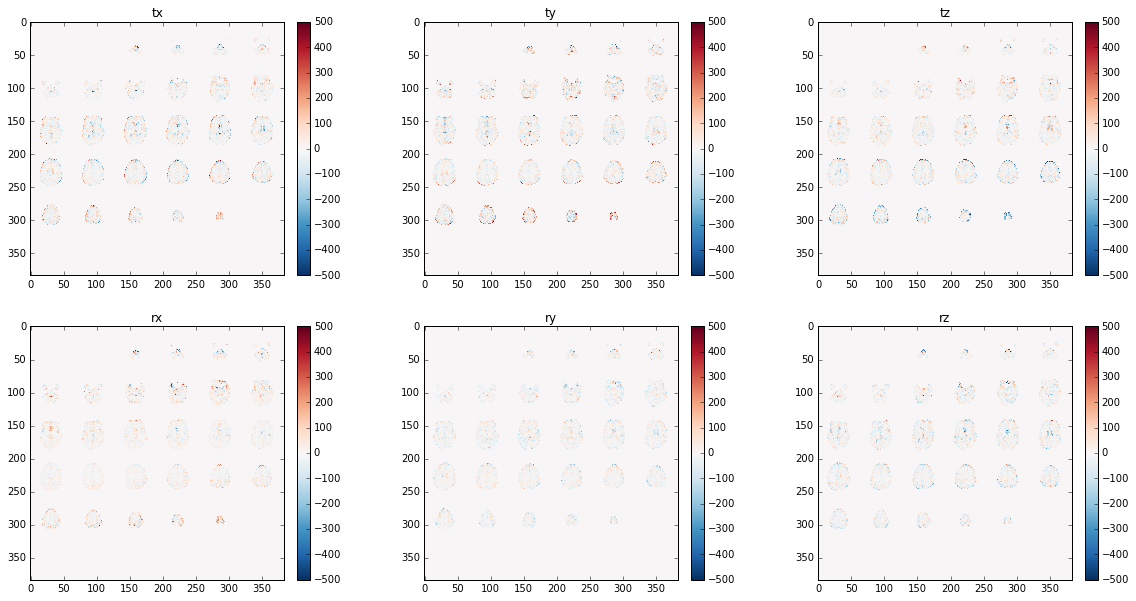

In [8]:
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,0]),lim=[-500,500])
plt.title('tx')
plt.subplot(2,3,2)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,1]),lim=[-500,500])
plt.title('ty')
plt.subplot(2,3,3)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,2]),lim=[-500,500])
plt.title('tz')
plt.subplot(2,3,4)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,3]),lim=[-500,500])
plt.title('rx')
plt.subplot(2,3,5)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,4]),lim=[-500,500])
plt.title('ry')
plt.subplot(2,3,6)
visu.mat(montage(getMap(lreg.coef_,mask_b)[:,:,:,5]),lim=[-500,500])
plt.title('rz')

In [7]:
def show_diff(ref_vals,pred_vals,mask,frame=10,cut=20):
    plt.figure(figsize=(15,5))
    ref_vol = getMap(ref_vals[frame,:],mask)
    lim_val = [ref_vol[:,:,cut].min(),ref_vol[:,:,cut].max()]
    plt.subplot(1,3,1)
    visu.mat(getMap(ref_vals[frame,:],mask)[:,:,cut],lim=lim_val)
    plt.subplot(1,3,2)
    visu.mat(getMap(pred_vals[frame,:],mask)[:,:,cut],lim=lim_val)
    plt.subplot(1,3,3)
    visu.mat(getMap((ref_vals-pred_vals)[frame,:],mask)[:,:,cut],lim=lim_val)
    
def show_report(ref_vals,pred_vals,mask,frames,cut=20):
    n_frames = len(frames)
    # R2
    R2 = getR2(ref_vals,pred_vals)
    
    fig=plt.figure(figsize=(15,5+5*len(frames)))
    ax = plt.subplot(n_frames+1,2,1)
    plt.title('R2 Mean:'+str(round(R2.mean(),3))+' Min:'+str(round(R2.min(),3))+' Max:'+str(round(R2.max(),3)))
    visu.mat(getMap(R2,mask)[:,:,20],lim=[-1,1])
    plt.subplot(n_frames+1,2,2)
    plt.title('R2 distribution')
    plt.hist(R2,100)
    
    # frames
    for ii in range(n_frames):
        ref_vol = getMap(ref_vals[frames[ii],:],mask)
        lim_val = [ref_vol[:,:,cut].min(),ref_vol[:,:,cut].max()]
        plt.subplot(n_frames+1,3,3+3*ii+1)
        visu.mat(getMap(ref_vals[frames[ii],:],mask)[:,:,cut],lim=lim_val)
        if ii == 0: plt.title('Reference')
        plt.ylabel('Frame '+str(frames[ii]))
        plt.subplot(n_frames+1,3,3+3*ii+2)
        visu.mat(getMap(pred_vals[frames[ii],:],mask)[:,:,cut],lim=lim_val)
        if ii == 0: plt.title('Prediction')
        plt.subplot(n_frames+1,3,3+3*ii+3)
        visu.mat(getMap((ref_vals-pred_vals)[frames[ii],:],mask)[:,:,cut],lim=lim_val)
        if ii == 0: plt.title('Difference')
    

## linear regression in a CV loop

In [11]:

kf = KFold(n=vol.shape[3], n_folds=10, shuffle=False,random_state=None)

ts = vol[mask_b].T
pred_vals = []
ref_vals = []
for train, test in kf:
    ## Train
    lreg_d = LinearRegression(fit_intercept=True,normalize=False)
    lreg_d.fit(Xdrift[train,:],ts[train,:])
    new_ts = ts-lreg_d.predict(Xdrift)
    
    lreg_md = LinearRegression(fit_intercept=True,normalize=False)
    lreg_md.fit(Xdrift[train,:],Xmotion[train,:])
    new_Xmotion = Xmotion - lreg_md.predict(Xdrift)
    
    # Learn the regression parameters to predict time series
    lreg_m = LinearRegression(fit_intercept=False,normalize=False)
    lreg_m.fit(new_Xmotion[train,:],new_ts[train,:])
    
    ## Test on independent data
    X_test = new_Xmotion[test,:]
    pred_vals.append(lreg_m.predict(X_test))
    
    ref_vals.append(new_ts[test,:])
    
    
print 'Average R2: ', getR2(np.vstack(ref_vals),np.vstack(pred_vals)).mean()

Average R2:  0.0727610586566


[ 0.48883843  0.60653567  0.4345842   0.26702386  0.21917324  0.40170175
  0.41339895  0.37901482  0.39835516  0.2093654 ]


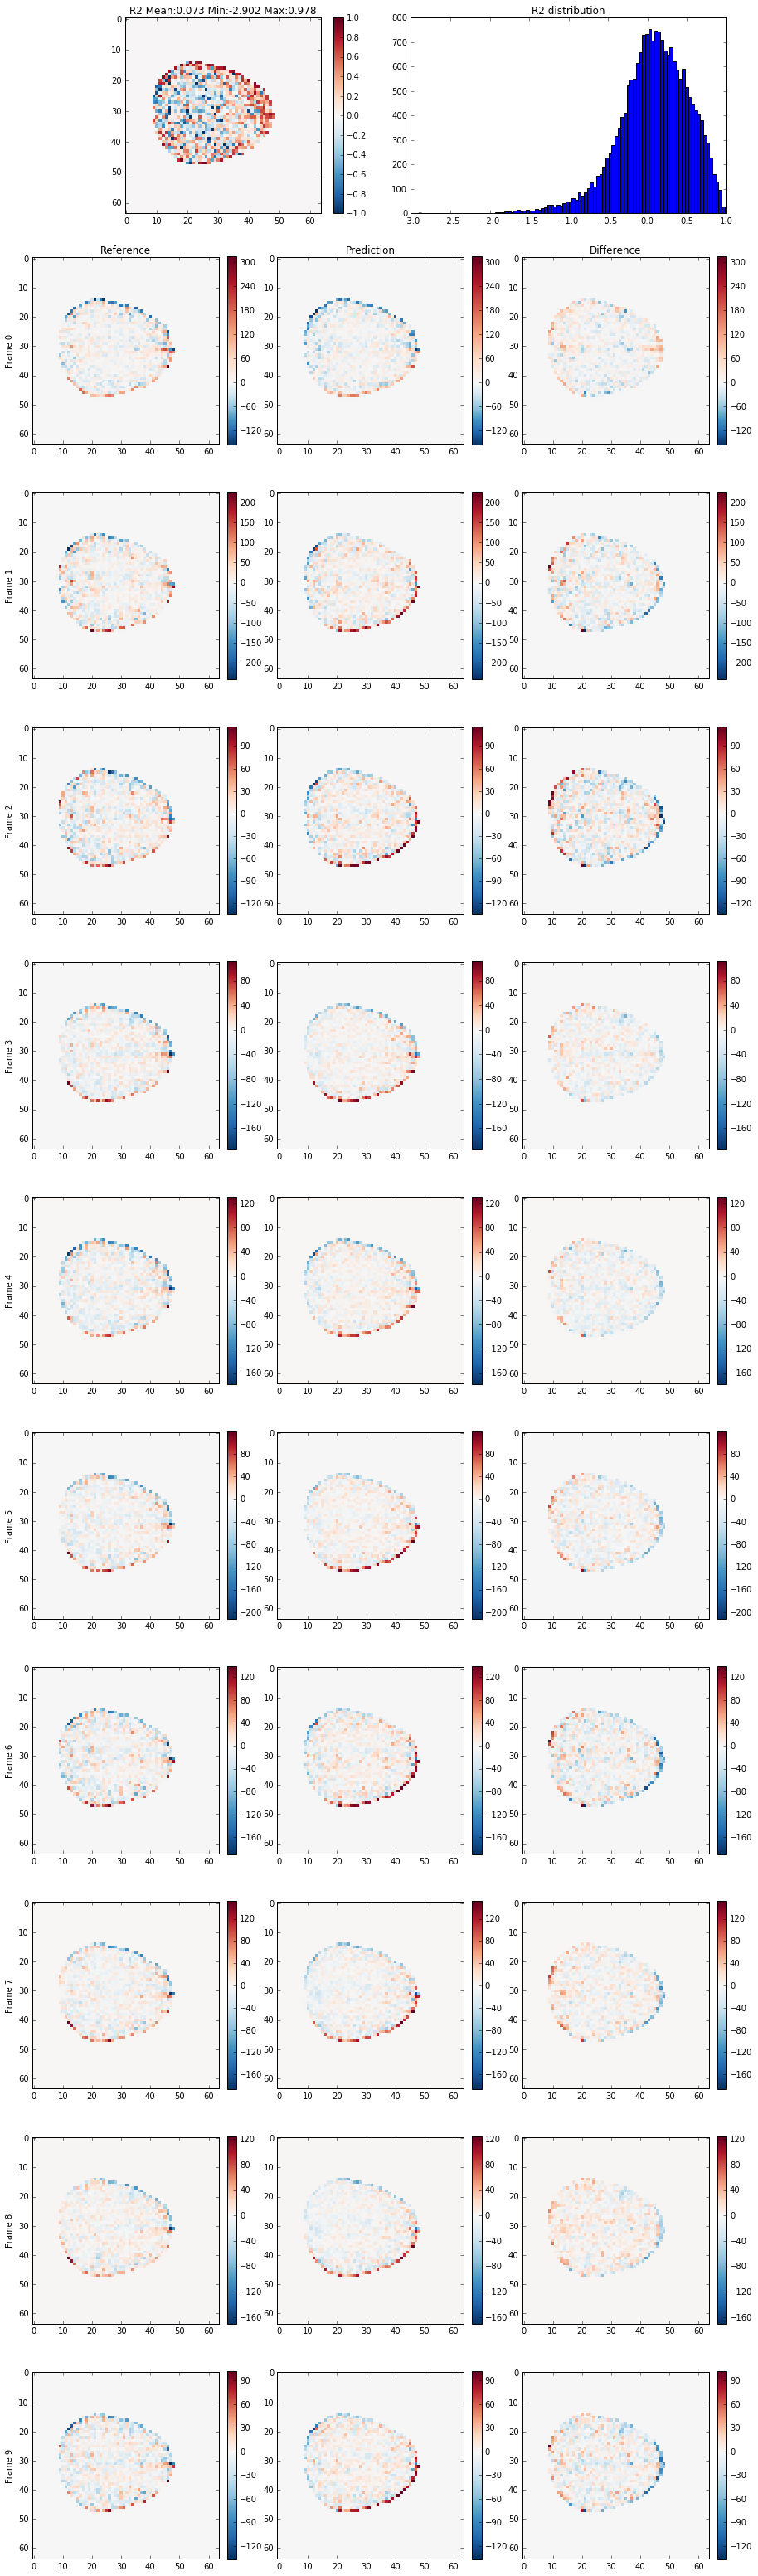

In [12]:
show_report(np.vstack(ref_vals),np.vstack(pred_vals),mask_b,frames=np.arange(0,10))
print fd[0:10]

# Fully connected 1 layer
Normalized input and output

Using Theano backend.
Using gpu device 0: GeForce GTX 550 Ti (CNMeM is disabled, cuDNN not available)

--------------------kfold 1--------------------
Train on 108 samples, validate on 27 samples
Epoch 1/50
108/108 [==============================] - 0s - loss: 0.9898 - val_loss: 1.0655
Epoch 2/50
108/108 [==============================] - 0s - loss: 0.9883 - val_loss: 1.0638
Epoch 3/50
108/108 [==============================] - 0s - loss: 0.9855 - val_loss: 1.0615
Epoch 4/50
108/108 [==============================] - 0s - loss: 0.9816 - val_loss: 1.0586
Epoch 5/50
108/108 [==============================] - 0s - loss: 0.9766 - val_loss: 1.0553
Epoch 6/50
108/108 [==============================] - 0s - loss: 0.9709 - val_loss: 1.0516
Epoch 7/50
108/108 [==============================] - 0s - loss: 0.9645 - val_loss: 1.0477
Epoch 8/50
108/108 [==============================] - 0s - loss: 0.9577 - val_loss: 1.0436
Epoch 9/50
108/108 [==============================] - 0s - loss: 0.9504 - val_loss: 1.0393
Epoch 10/50
108/108 [==============================] - 0s - loss: 0.9430 - val_loss: 1.0

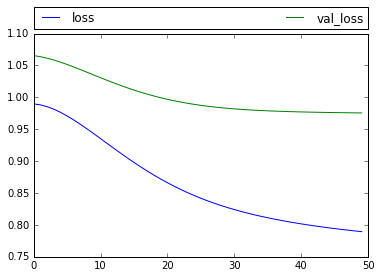

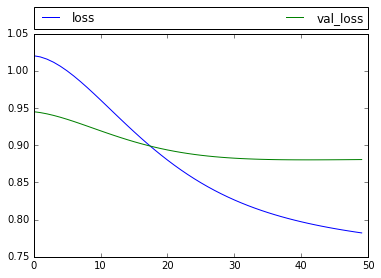

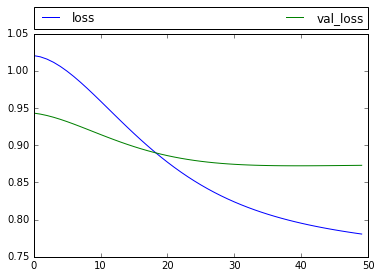

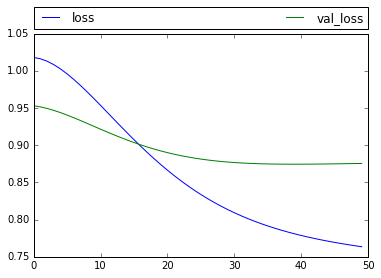

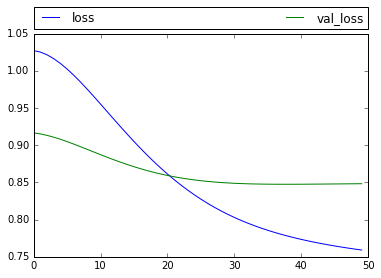

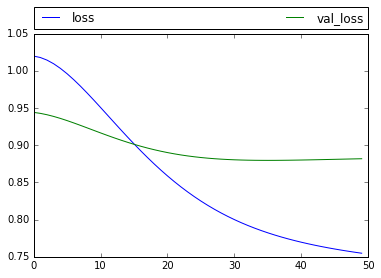

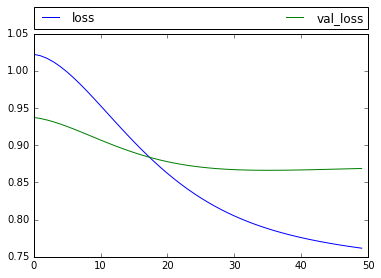

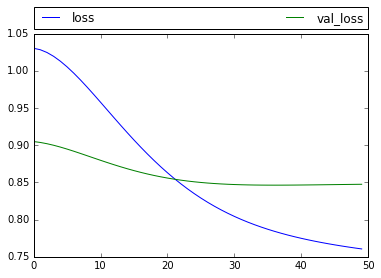

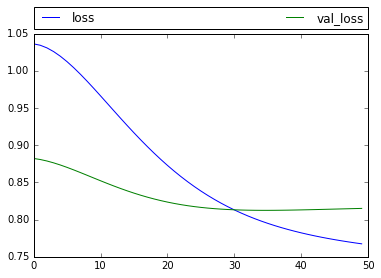

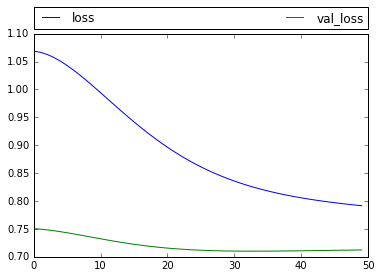

In [13]:
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import StandardScaler

def build_model(output_size):
    model = Sequential()
    model.add(Dense(output_size, input_dim=6,init='uniform'))
    model.add(Activation('linear'))

    sgd = SGD(lr=20, decay=0.0, momentum=0.9, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    return model


ts = vol[mask_b].T
nb_epoch = 50
kf = KFold(n=ts.shape[0], n_folds=10, shuffle=False,random_state=None)

pred_vals = []
ref_vals = []
k=1
for train, test in kf:
    
    ssx = StandardScaler()
    ssy = StandardScaler()
    #print train
    print ('-'*20)+'kfold '+ str(k)+('-'*20)
    k+=1
    # Train
    lreg_d = LinearRegression(fit_intercept=True,normalize=False)
    lreg_d.fit(Xdrift[train,:],ts[train,:])
    new_ts = ts-lreg_d.predict(Xdrift)
    
    lreg_md = LinearRegression(fit_intercept=True,normalize=False)
    lreg_md.fit(Xdrift[train,:],Xmotion[train,:])
    new_Xmotion = Xmotion - lreg_md.predict(Xdrift)
    
    # Learn the regression parameters to predict time series
    model = build_model(ts.shape[1])
    hist = model.fit(ssx.fit_transform(new_Xmotion[train,:]), ssy.fit_transform(new_ts[train,:]), nb_epoch=nb_epoch, batch_size=ts.shape[0],validation_split=0.2)
    
    plt.figure()
    plt.plot(range(nb_epoch),hist.history['loss'],range(nb_epoch),hist.history['val_loss'])
    #plt.plot(range(nb_epoch),hist.history['loss'])
    plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    
    ## Test on independent data
    X_test = ssx.transform(new_Xmotion[test,:])
    pred_vals.append(ssy.inverse_transform(model.predict(X_test)))
    
    ref_vals.append(new_ts[test,:])
    
    
print getR2(np.vstack(ref_vals),np.vstack(pred_vals)).mean()


[ 0.48883843  0.60653567  0.4345842   0.26702386  0.21917324  0.40170175
  0.41339895  0.37901482  0.39835516  0.2093654 ]


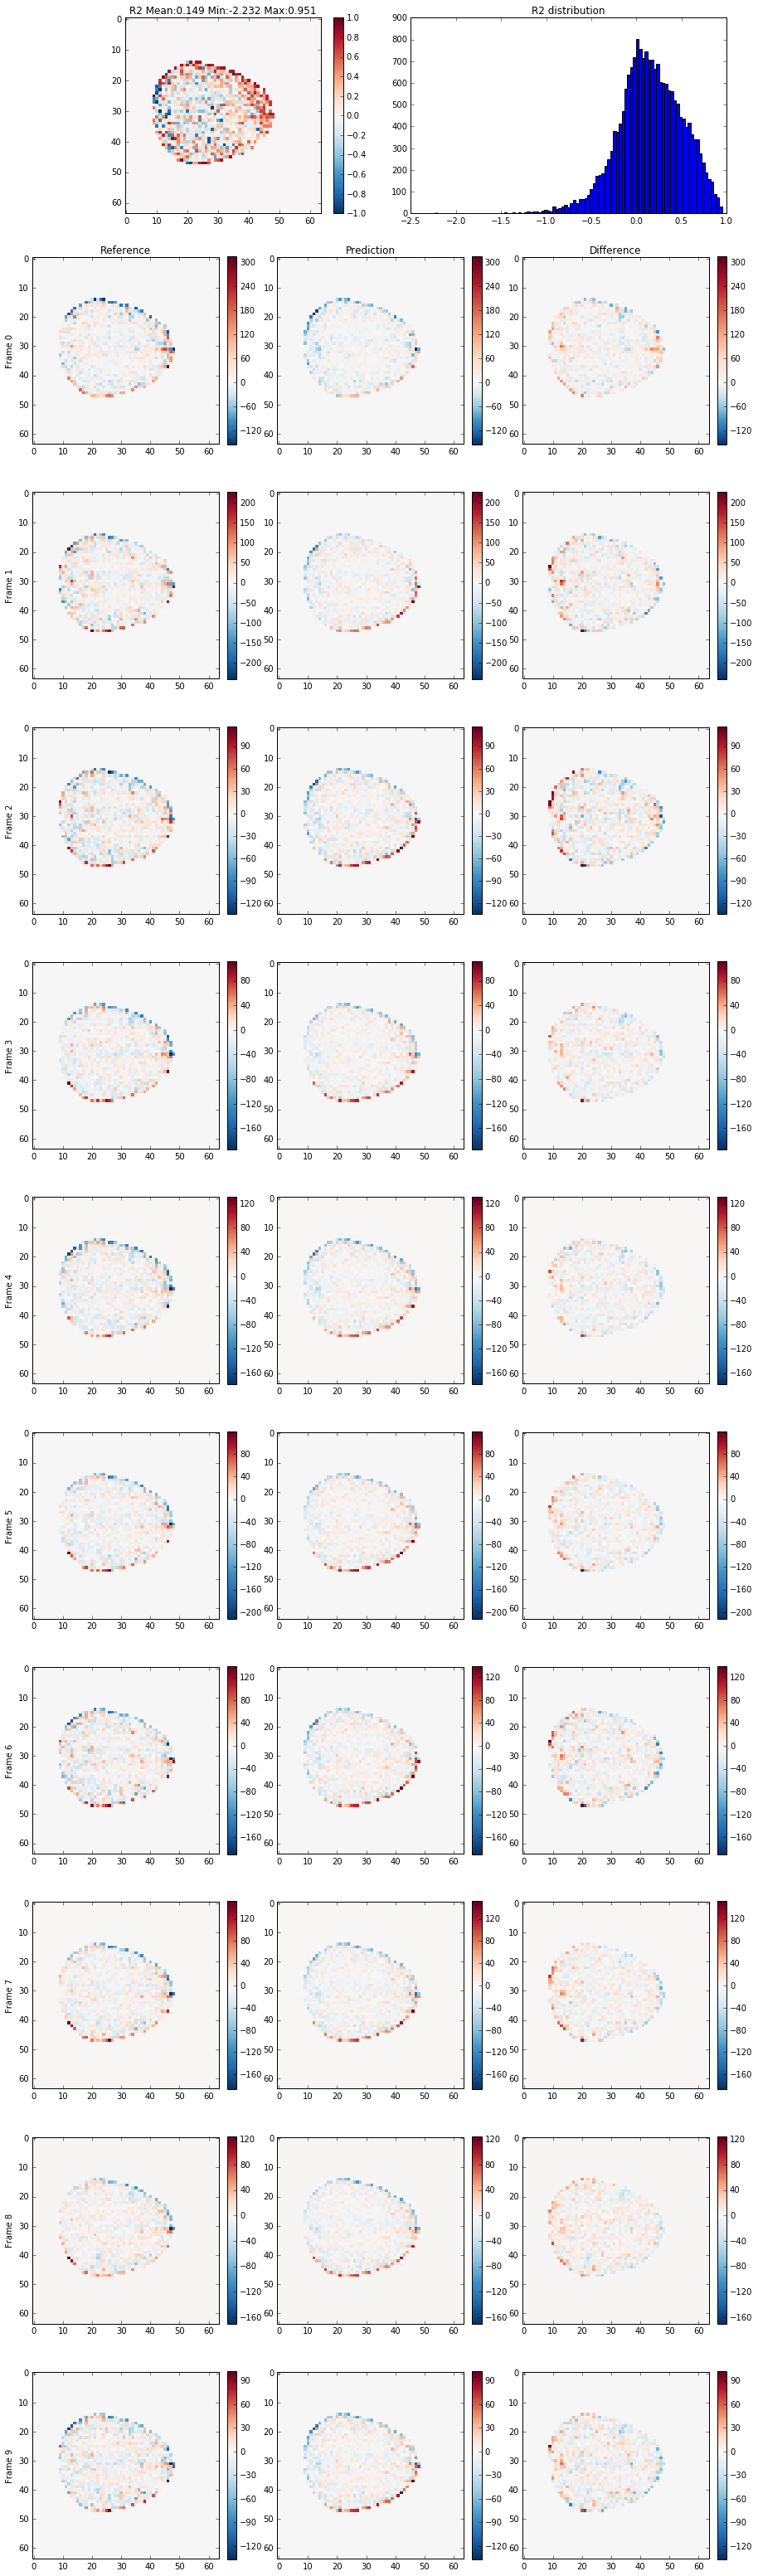

In [14]:
show_report(np.vstack(ref_vals),np.vstack(pred_vals),mask_b,frames=np.arange(0,10))
print fd[0:10]

# Non-liear model Relu hidden layer

--------------------kfold 1--------------------
--------------------kfold 2--------------------
--------------------kfold 3--------------------
--------------------kfold 4--------------------
--------------------kfold 5--------------------
--------------------kfold 6--------------------
--------------------kfold 7--------------------
--------------------kfold 8--------------------
--------------------kfold 9--------------------
--------------------kfold 10--------------------
Average R2:  0.122778638955


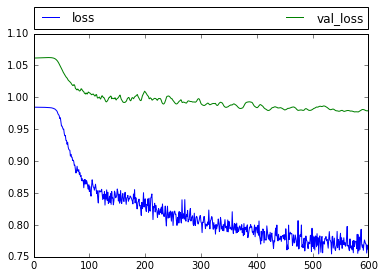

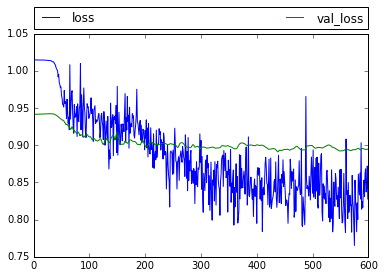

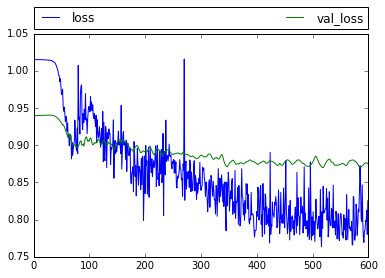

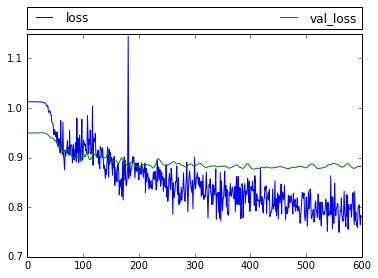

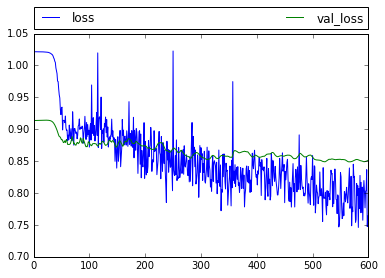

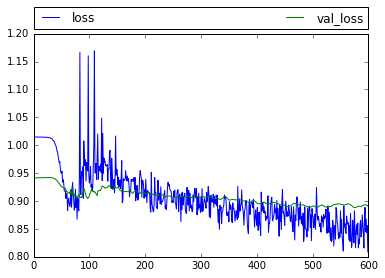

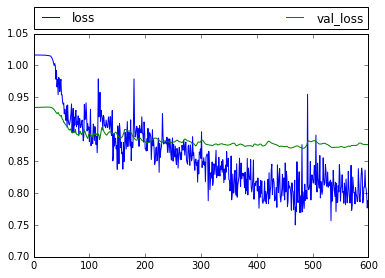

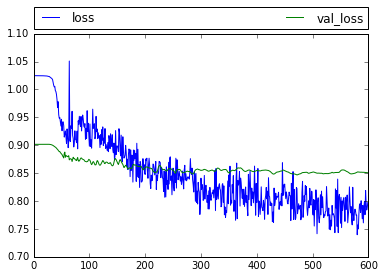

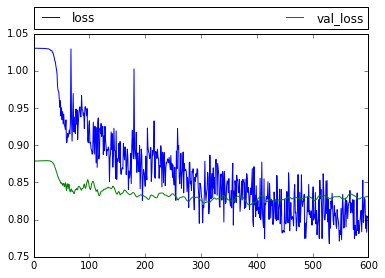

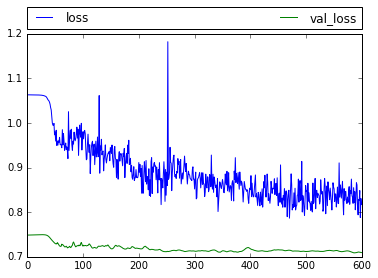

In [11]:
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from sklearn.preprocessing import StandardScaler


def build_model(output_size):
    model = Sequential()
    model.add(Dense(64, input_dim=6,init='uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64,init='uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(output_size,init='uniform'))
    model.add(Activation('linear'))

    sgd = SGD(lr=20, decay=0.015, momentum=0.9, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    return model


nb_epoch = 600
validation_split = 0.2
ts = vol[mask_b].T
kf = KFold(n=ts.shape[0], n_folds=10, shuffle=False,random_state=None)

pred_vals = []
ref_vals = []
k=1
for train, test in kf:
    
    ssx = StandardScaler()
    ssy = StandardScaler()
    
    #print train
    print ('-'*20)+'kfold '+ str(k)+('-'*20)
    k+=1
    # Train
    lreg_d = LinearRegression(fit_intercept=True,normalize=False)
    lreg_d.fit(Xdrift[train,:],ts[train,:])
    new_ts = ts-lreg_d.predict(Xdrift)
    
    lreg_md = LinearRegression(fit_intercept=True,normalize=False)
    lreg_md.fit(Xdrift[train,:],Xmotion[train,:])
    new_Xmotion = Xmotion - lreg_md.predict(Xdrift)
    
    # Learn the regression parameters to predict time series
    model = build_model(ts.shape[1])
    hist = model.fit(ssx.fit_transform(new_Xmotion[train,:]), ssy.fit_transform(new_ts[train,:]),verbose=0, nb_epoch=nb_epoch, batch_size=ts.shape[0],validation_split=validation_split)
    
    plt.figure()
    if validation_split == 0.:
        plt.plot(range(nb_epoch),hist.history['loss'])
    else:
        plt.plot(range(nb_epoch),hist.history['loss'],range(nb_epoch),hist.history['val_loss'])
    plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    
    ## Test on independent data
    X_test = ssx.transform(new_Xmotion[test,:])
    pred_vals.append(ssy.inverse_transform(model.predict(X_test)))
    
    ref_vals.append(new_ts[test,:])
    
    
    
print 'Average R2: ',getR2(np.vstack(ref_vals),np.vstack(pred_vals)).mean()


[ 0.48883843  0.60653567  0.4345842   0.26702386  0.21917324  0.40170175
  0.41339895  0.37901482  0.39835516  0.2093654 ]


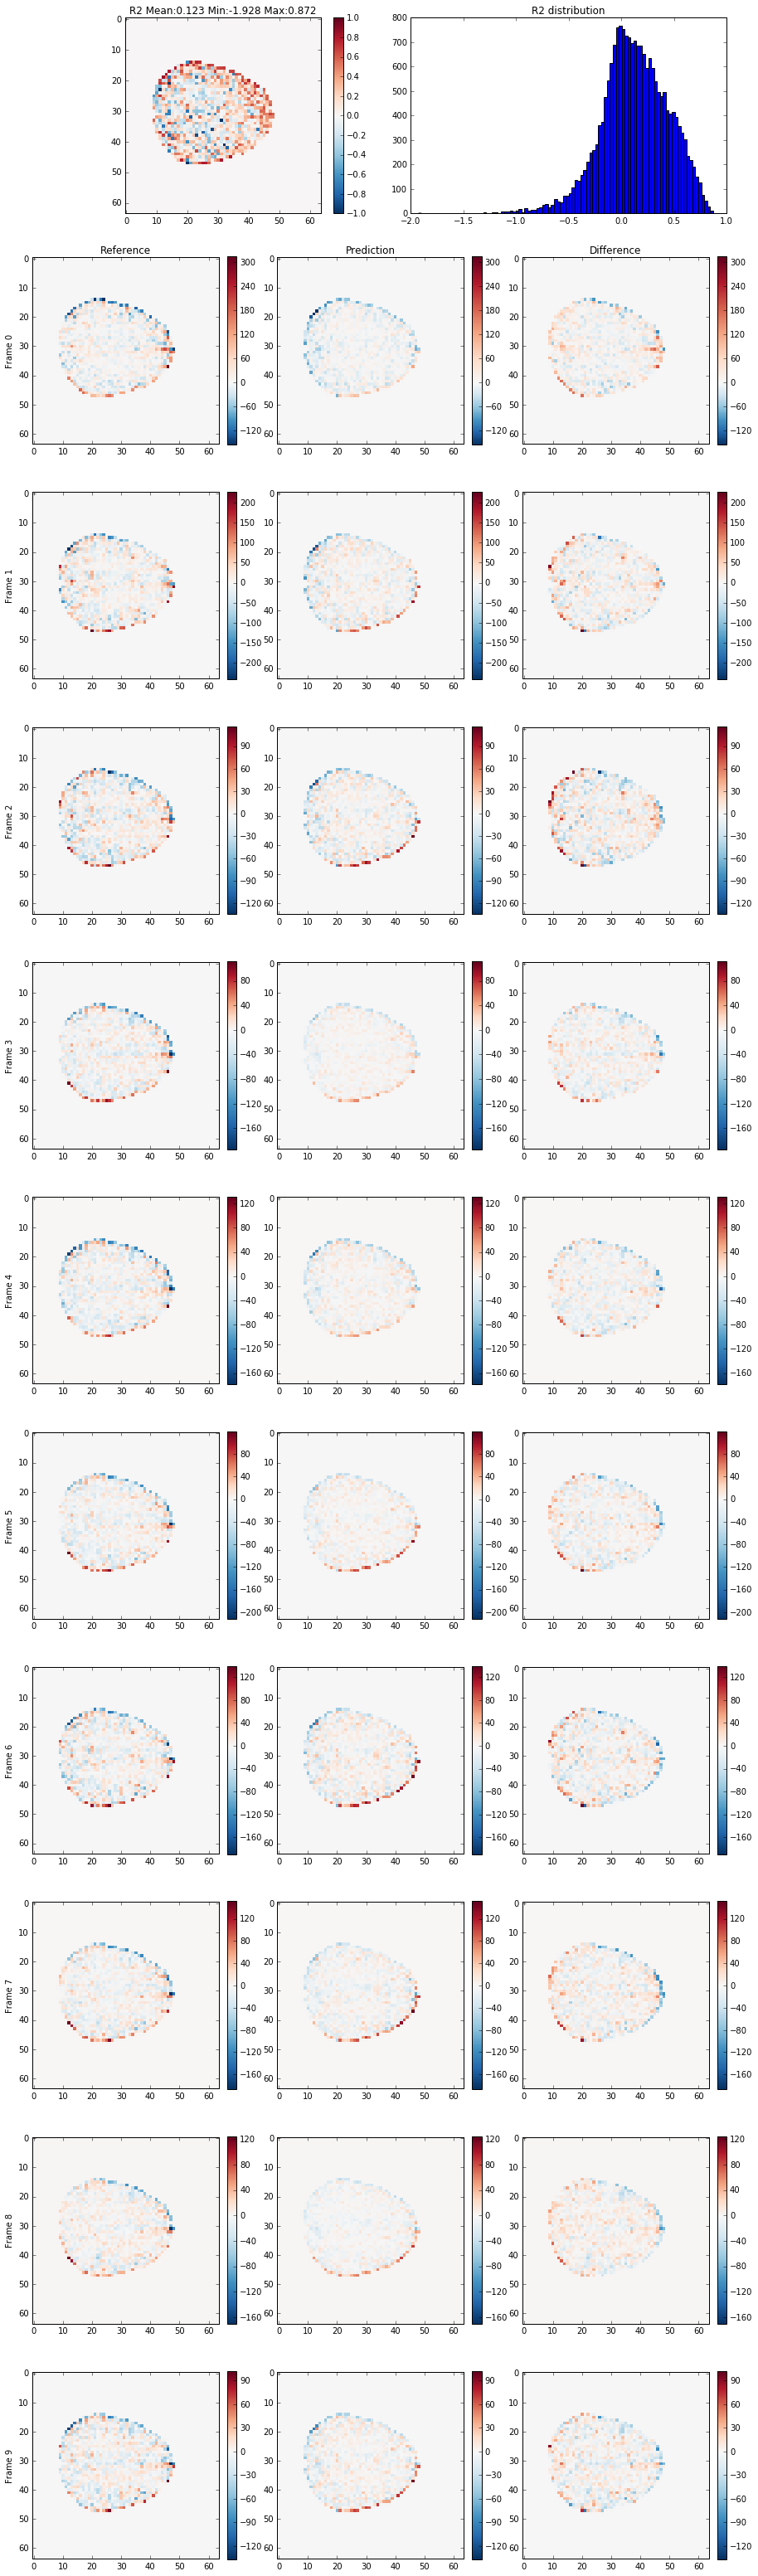

In [12]:
show_report(np.vstack(ref_vals),np.vstack(pred_vals),mask_b,frames=np.arange(0,10))
print fd[0:10]

# None-linear Tanh activation layers

--------------------kfold 1--------------------
--------------------kfold 2--------------------
--------------------kfold 3--------------------
--------------------kfold 4--------------------
--------------------kfold 5--------------------
--------------------kfold 6--------------------
--------------------kfold 7--------------------
--------------------kfold 8--------------------
--------------------kfold 9--------------------
--------------------kfold 10--------------------
Average R2:  0.171906831789


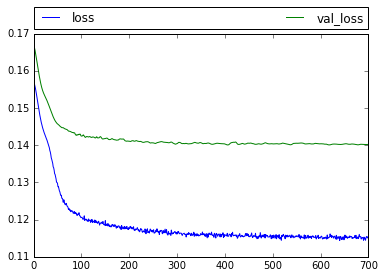

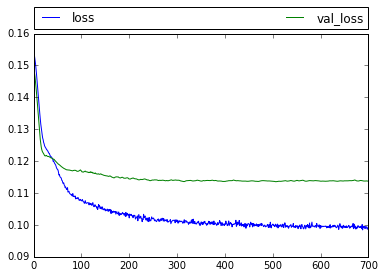

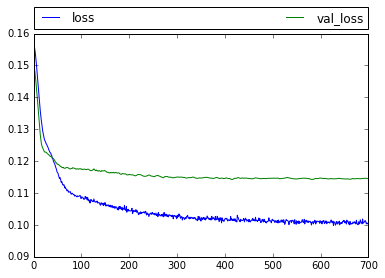

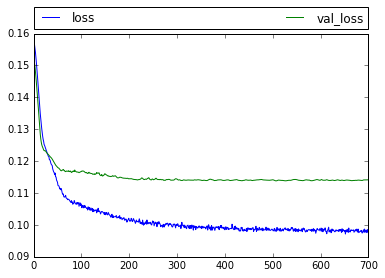

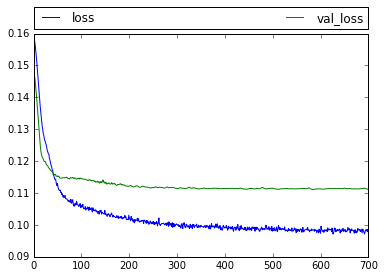

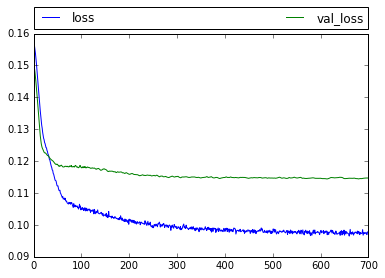

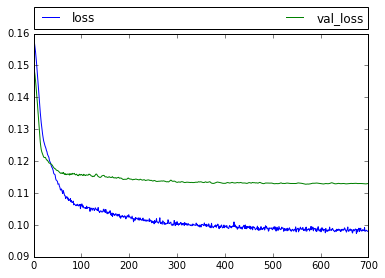

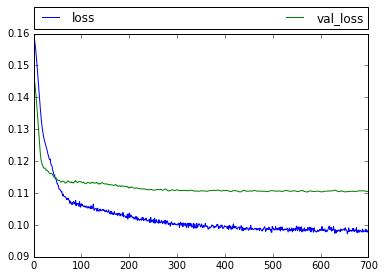

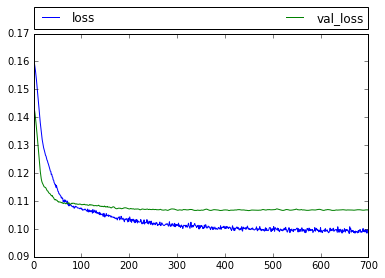

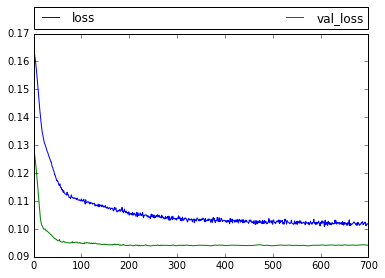

In [13]:
from keras.utils import np_utils, generic_utils
from keras.optimizers import SGD, RMSprop
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dropout
from sklearn.preprocessing import StandardScaler,MinMaxScaler


def build_model(output_size):
    model = Sequential()
    model.add(Dense(128, input_dim=6,init='uniform'))
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128,init='uniform'))
    model.add(Activation('tanh'))
    model.add(Dropout(0.5))

    model.add(Dense(output_size,init='uniform'))
    model.add(Activation('linear'))

    sgd = SGD(lr=70, decay=0.04, momentum=0.9, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer=sgd)
    return model


nb_epoch = 700
validation_split = 0.2
ts = vol[mask_b].T
kf = KFold(n=ts.shape[0], n_folds=10, shuffle=False,random_state=None)

pred_vals = []
ref_vals = []
k=1
for train, test in kf:
    
    ssx = MinMaxScaler(feature_range=(-1,1))
    ssy = MinMaxScaler(feature_range=(-1,1))
    
    #print train
    print ('-'*20)+'kfold '+ str(k)+('-'*20)
    k+=1
     # Train
    lreg_d = LinearRegression(fit_intercept=True,normalize=False)
    lreg_d.fit(Xdrift[train,:],ts[train,:])
    new_ts = ts-lreg_d.predict(Xdrift)
    
    lreg_md = LinearRegression(fit_intercept=True,normalize=False)
    lreg_md.fit(Xdrift[train,:],Xmotion[train,:])
    new_Xmotion = Xmotion - lreg_md.predict(Xdrift)
    
    # Learn the regression parameters to predict time series
    model = build_model(ts.shape[1])
    hist = model.fit(ssx.fit_transform(new_Xmotion[train,:]), ssy.fit_transform(new_ts[train,:]),verbose=0, nb_epoch=nb_epoch, batch_size=ts.shape[0],validation_split=validation_split)
    
    plt.figure()
    if validation_split == 0.:
        plt.plot(range(nb_epoch),hist.history['loss'])
    else:
        plt.plot(range(nb_epoch),hist.history['loss'],range(nb_epoch),hist.history['val_loss'])
    plt.legend(['loss','val_loss'],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    
    ## Test on independent data
    X_test = ssx.transform(new_Xmotion[test,:])
    pred_vals.append(ssy.inverse_transform(model.predict(X_test)))
    
    ref_vals.append(new_ts[test,:])
    
    
    
print 'Average R2: ',getR2(np.vstack(ref_vals),np.vstack(pred_vals)).mean()


[ 0.48883843  0.60653567  0.4345842   0.26702386  0.21917324  0.40170175
  0.41339895  0.37901482  0.39835516  0.2093654 ]


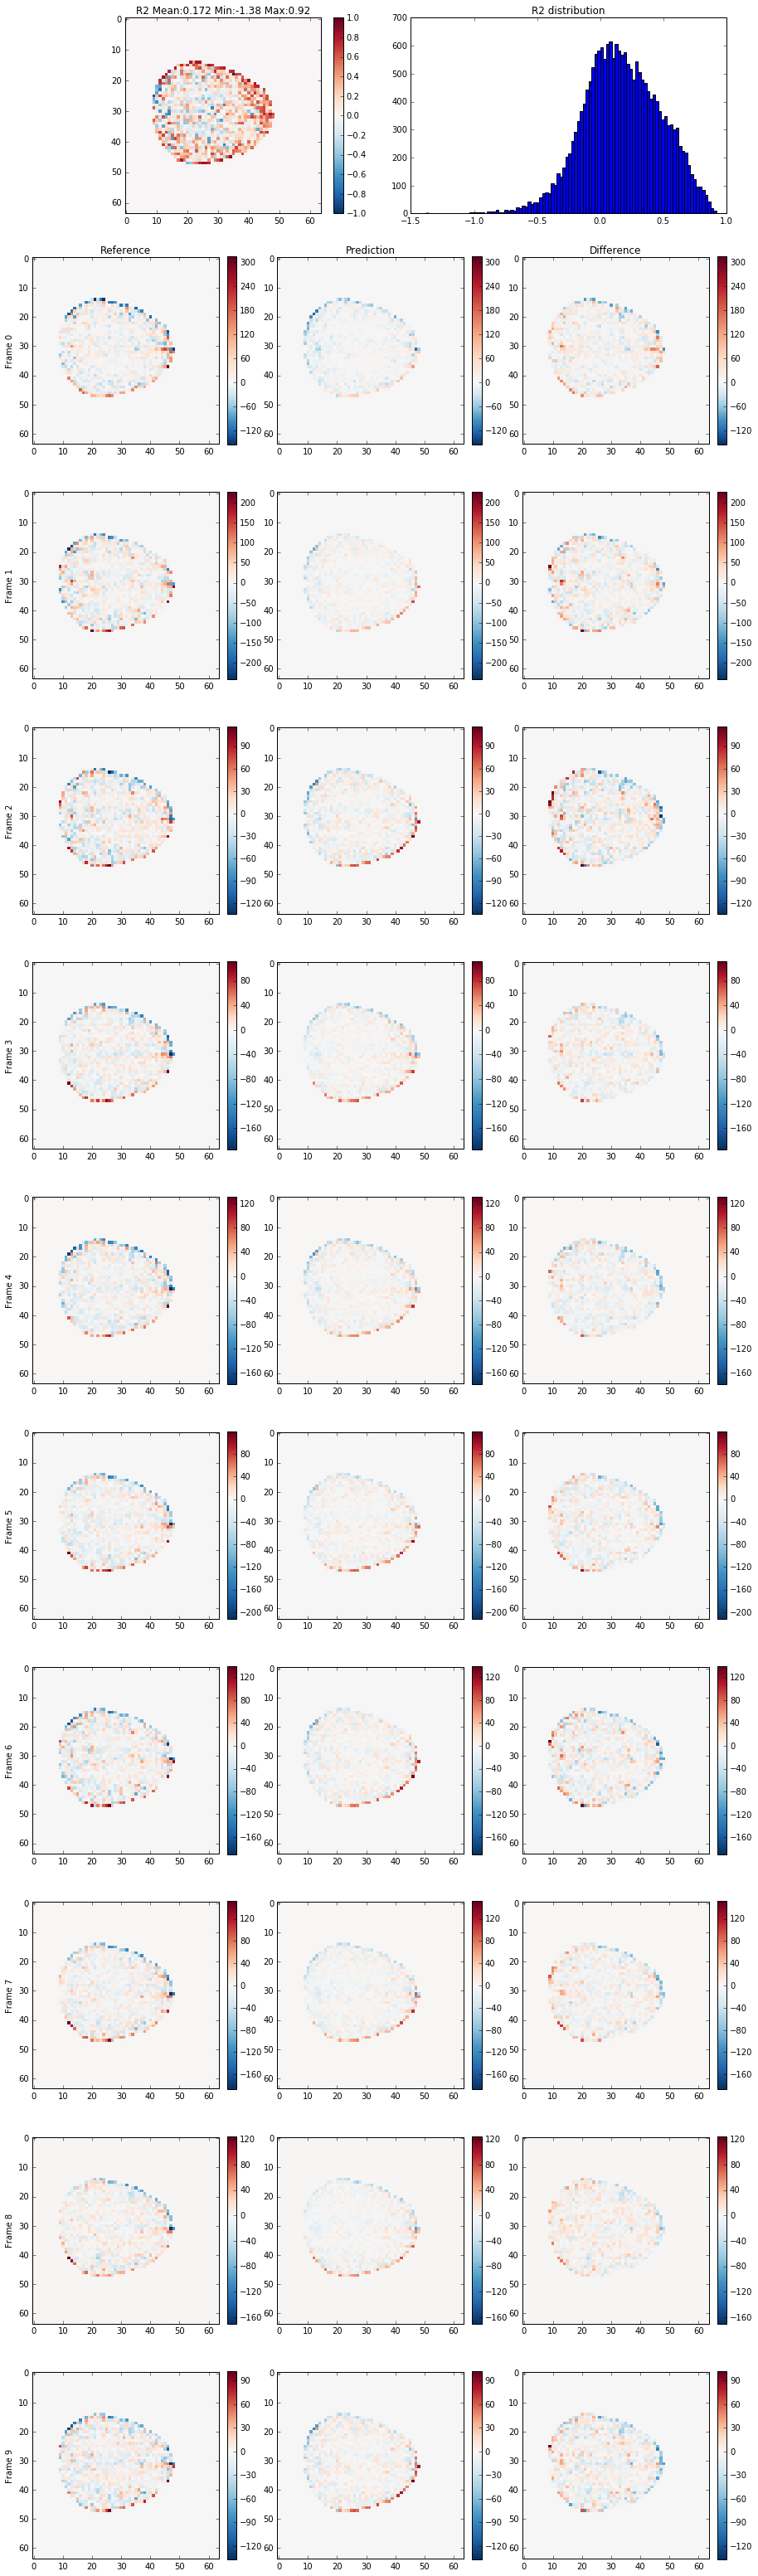

In [14]:
show_report(np.vstack(ref_vals),np.vstack(pred_vals),mask_b,frames=np.arange(0,10))
print fd[0:10]